# Project Overview

In this capstone project I am going attempt to predict when a Broadway show should close.  The idea behind this development is that an interface would be developed for producers that would allow them to enter their numbers from the previous week and determine if they are in a "red zone", therefore closing.  This feature was engineered by marking the last 6 weeks of a performance with a 1 and every other week with a 0.  The idea is that the computer picks up on the fact that the numbers decline at a more rapid pace during the weeks marked with 1.

I have divided the project up into three parts:

**Baseline Modeling**
In this section is an in depth Exploratory Data Analysis of Broadway weekly grosses, types of shows, and other important features that may influence whether a show will close or not.  SVM and Random Forest are used as baseline modeling techniques while addressing things like class imabalance.  

**ANN for Broadway Grosses**
Using the Keras API an Artificial Neural Network is constructed to use sophisticated algorithms to determine if a Broadway show should close or not.

**Wicked Time Series Analysis**
The core to this data is the passage of time and how much money the show is making.  It is essential to take an in depth look at time series, how it can influence our predictions, and its components like seasonality.  It is concluded with a prediction of how much money the Broadway show Wicked lost the first year of COVID-19.

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

# The Data

This data was orginally parsed from the Broadway League website and can be found [here](https://www.broadwayleague.com/research/grosses-broadway-nyc/#weekly_grosses).

The Broadway League is an internationally recognized organization that maintains the standards and efficacy of Broadway shows.  They are not connected with the production companies and they do not record the grosses.  The grosses are recorded by the box office that remains a neutral 3rd party.  
The original data came with 12 features:

|Feature|Description|
|:----:|:----:|
|date|Past 5 years of all Broadway data.|
|show|Name of the show.|
|type|Distinguished by Play, Musical, or Special.|
|theatre|Which physical theatre the show takes place at.|
|previews|How many of the performances were previews.|
|performances|How many performances occured not including previews.|
|grosses|Total revenue generated before running costs.|
|prev week grosses|The revenue generated from the previous week.|
|GG%GP|This is the percentage of the revenue generated out of the possible grossings. Number is defined by every seat in the house being sold at full price.|
|attendance|How many people attended the Performance.|
|prev week attendance|How many people attended last week.|
|%capacity|How much of the theatre was full.|

## Feture Engineering

In addition I added four rows as additional features:

|Feature|Description|
|:---:|:---:|
|Close Month| This demarcates the month of closing.|
|Genre|Includes: Mystery, Comedy, Drama, Alternative, Jukebox, Tragedy|
|Tony Noms|The number of Tony nominations the show recieved.|
|Tony Awards|The number of Tony awards the show won.|

The Features were all originally collected and stored in a large Excel file.  
Creating a closing month feature was the vital column that my argument leans on.  The idea is that we get the computer to pick up on the fact that the show is not doing well and therefore is closing.  By marking the last 6 weeks of a shows life we can try to run sophisticated algorithms that attempt to detect when that will be based on other features.

In [2]:
#Load data
df = pd.read_excel('Broadway_Grosses.xlsx')

In [3]:
##Initial look at the data and it read in nicely.
df.head()

date  show  type theatre  previews  performances  grosses  \
0 2017-05-21  1984  Play  Hudson         4             0   212626   
1 2017-05-28  1984  Play  Hudson         7             0   298438   
2 2017-06-04  1984  Play  Hudson         8             0   282053   
3 2017-06-11  1984  Play  Hudson         8             0   288446   
4 2017-06-18  1984  Play  Hudson         8             0   301461   

  prev_week_gross  GG%GP  attend  prev_week_attend  %cap  close_month  \
0               $   0.48    3378               NaN  0.87            0   
1          212626   0.45    5079            3378.0  0.75            0   
2          298438   0.36    5230            5079.0  0.67            0   
3          282053   0.37    5554            5230.0  0.72            0   
4          288446   0.39    6018            5554.0  0.78            0   

     genre  tony_noms  tony_awards  
0  Mystery          1            0  
1  Mystery          1            0  
2  Mystery          1            0  
3  Mystery          1            0  
4  Mystery          1            0

In [4]:
#Looking to makes sure that shows are only categorized as musical, play, or special.
df['type'].nunique()

3

In [5]:
df['type'].unique()

array(['Play', 'Musical', 'Special'], dtype=object)

In [6]:
#Noting that we have over 8,000 rows but only working with 233 shows.
print('----------------------------------------------------------')
print('The number of Broadway Shows in this dataset is:',df['show'].nunique())

----------------------------------------------------------
The number of Broadway Shows in this dataset is: 233


In [7]:
df['show'].unique()

array([1984, 'A CHRISTMAS CAROL 2019', "A SOLDIER'S PLAY",
       "AIN'T TOO PROUD", 'A BRONX TALE THE MUSICAL',
       'A DELICATE BALANCE 2014', "A DOLL'S HOUSE, PART 2",
       "A GENTLEMAN'S GUIDE TO LOVE AND MURDER",
       'A VIEW FROM THE BRIDGE 2015', 'AIRLINE HIGHWAY', 'ALADDIN',
       'ALL MY SONS 2019', 'AMERICAN SON', 'AMERICAN UTOPIA',
       'ALLEGIANCE', 'ALTON BROWN LIVE: EAT YOUR SCIENCE',
       'AMAZING GRACE', 'AMÉLIE', 'AMERICAN PSYCHO', 'AN ACT OF GOD',
       'AN ACT OF GOD 2016', 'AN AMERICAN IN PARIS', 'ANASTASIA',
       'ANGELS IN AMERICA 2018', 'BANDSTAND', 'BARRY MANILOW',
       'BE MORE CHILL', 'BEAUTIFUL', 'BEETLEJUICE', 'BETRAYAL 2019',
       'BURN THIS 2019', 'BERNHARDT/HAMLET', 'BLACK TO THE FUTURE',
       'BLACKBIRD', 'BRIGHT STAR', "CABARET '14", 'CAROUSEL 2018',
       'CATS 2016', 'CELEBRITY AUTOBIOGRAPHY',
       'CHARLIE AND THE CHOCOLATE FACTORY', 'CHICAGO', 'CHOIR BOY',
       'CHILDREN OF A LESSER GOD 2018', 'CHINA DOLL', 'COME FROM AWAY',

In [8]:
# Changing the show names from all caps to standard format.
df['show'] = df['show'].str.capitalize()

## Handling missing values

In [9]:
# This is an extremely clean and tight data set since it was custom created.  
# The 213 missing data points account for the first week of a show since there would be no previous records for a new show.
df.isna().sum()

date                  0
show                 20
type                  0
theatre               0
previews              0
performances          0
grosses               0
prev_week_gross       0
GG%GP                 0
attend                0
prev_week_attend    213
%cap                  0
close_month           0
genre                 0
tony_noms             0
tony_awards           0
dtype: int64

In [10]:
#getting rid of the few null values.
df = df.dropna()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7978 entries, 21 to 8209
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              7978 non-null   datetime64[ns]
 1   show              7978 non-null   object        
 2   type              7978 non-null   object        
 3   theatre           7978 non-null   object        
 4   previews          7978 non-null   int64         
 5   performances      7978 non-null   int64         
 6   grosses           7978 non-null   int64         
 7   prev_week_gross   7978 non-null   object        
 8   GG%GP             7978 non-null   float64       
 9   attend            7978 non-null   int64         
 10  prev_week_attend  7978 non-null   float64       
 11  %cap              7978 non-null   float64       
 12  close_month       7978 non-null   int64         
 13  genre             7978 non-null   object        
 14  tony_noms         7978 

In [12]:
#For whatever reason prev_week_gross is an object and we need it as an integer or float for analytic purposes.
df['prev_week_gross'] = df['prev_week_gross'].values.astype('float32')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7978 entries, 21 to 8209
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              7978 non-null   datetime64[ns]
 1   show              7978 non-null   object        
 2   type              7978 non-null   object        
 3   theatre           7978 non-null   object        
 4   previews          7978 non-null   int64         
 5   performances      7978 non-null   int64         
 6   grosses           7978 non-null   int64         
 7   prev_week_gross   7978 non-null   float32       
 8   GG%GP             7978 non-null   float64       
 9   attend            7978 non-null   int64         
 10  prev_week_attend  7978 non-null   float64       
 11  %cap              7978 non-null   float64       
 12  close_month       7978 non-null   int64         
 13  genre             7978 non-null   object        
 14  tony_noms         7978 

In [14]:
#Taking a general look at numbers.  This is pretty normally distributed data with some outliers.
df.describe()

previews  performances       grosses  prev_week_gross        GG%GP  \
count  7978.000000   7978.000000  7.978000e+03     7.978000e+03  7978.000000   
mean      0.500376      7.429556  9.756514e+05     9.668879e+05     0.736296   
std       1.830696      1.968312  5.829954e+05     5.863859e+05     0.248156   
min       0.000000      0.000000  4.849600e+04     3.257400e+04     0.030000   
25%       0.000000      8.000000  5.825955e+05     5.719565e+05     0.540000   
50%       0.000000      8.000000  8.381615e+05     8.310565e+05     0.710000   
75%       0.000000      8.000000  1.209606e+06     1.203708e+06     0.930000   
max       8.000000     17.000000  4.041493e+06     4.041493e+06     1.700000   

             attend  prev_week_attend         %cap  close_month    tony_noms  \
count   7978.000000       7978.000000  7978.000000  7978.000000  7978.000000   
mean    8512.940963       8432.167837     0.870223     0.129732     6.666834   
std     2827.493530       2889.371202     0.136111     0.336029     4.849554   
min     1384.000000        500.000000     0.230000     0.000000     0.000000   
25%     6474.250000       6387.500000     0.780000     0.000000     2.000000   
50%     8107.000000       8060.500000     0.900000     0.000000     7.000000   
75%    10483.750000      10447.750000     0.990000     0.000000    10.000000   
max    24305.000000      17517.000000     1.040000     1.000000    16.000000   

       tony_awards  
count  7978.000000  
mean      2.755076  
std       3.325390  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       5.000000  
max      11.000000

In [15]:
df.isna().sum()

date                0
show                0
type                0
theatre             0
previews            0
performances        0
grosses             0
prev_week_gross     0
GG%GP               0
attend              0
prev_week_attend    0
%cap                0
close_month         0
genre               0
tony_noms           0
tony_awards         0
dtype: int64

In [16]:
#setting the date as the index for ease of use, note that object type was imported as a datetime64.
df = df.set_index('date')

In [17]:
df.head()

show  type theatre  previews  performances  \
date                                                                       
2019-11-17  A christmas carol 2019  Play  Lyceum         8             0   
2019-11-24  A christmas carol 2019  Play  Lyceum         1             7   
2019-12-01  A christmas carol 2019  Play  Lyceum         0             9   
2019-12-08  A christmas carol 2019  Play  Lyceum         0             8   
2019-12-15  A christmas carol 2019  Play  Lyceum         0             8   

            grosses  prev_week_gross  GG%GP  attend  prev_week_attend  %cap  \
date                                                                          
2019-11-17   257525         106450.0   0.30    4194            1651.0  0.62   
2019-11-24   384493         257525.0   0.45    5590            4194.0  0.82   
2019-12-01   734745         384493.0   0.77    5988            5590.0  0.78   
2019-12-08   757702         734745.0   0.90    6164            5988.0  0.91   
2019-12-15   822983         757702.0   0.97    6619            6164.0  0.98   

            close_month     genre  tony_noms  tony_awards  
date                                                       
2019-11-17            0  Seasonal          5            3  
2019-11-24            0  Seasonal          5            3  
2019-12-01            0  Seasonal          5            3  
2019-12-08            0  Seasonal          5            3  
2019-12-15            0  Seasonal          5            3

# Feature Engineering

In [18]:
# 1. The difference in grosses from the previous week
df['gross_diff'] = df['grosses'] - df['prev_week_gross']

In [19]:
# 2. The differnce in attendance from the previous week
df['att_diff'] = df['attend'] - df['prev_week_attend']

In [20]:
# 3. The size of the theatre
df['house_size'] = np.round(df['attend'] / df['%cap'])

In [21]:
# 4. The average ticket price that week
df['tkt_price'] = (df['grosses'] / df['GG%GP']) / df['house_size']

In [22]:
df.head(50)

show     type            theatre  previews  \
date                                                                       
2019-11-17  A christmas carol 2019     Play             Lyceum         8   
2019-11-24  A christmas carol 2019     Play             Lyceum         1   
2019-12-01  A christmas carol 2019     Play             Lyceum         0   
2019-12-08  A christmas carol 2019     Play             Lyceum         0   
2019-12-15  A christmas carol 2019     Play             Lyceum         0   
2019-12-22  A christmas carol 2019     Play             Lyceum         0   
2019-12-29  A christmas carol 2019     Play             Lyceum         0   
2020-01-05  A christmas carol 2019     Play             Lyceum         0   
2020-01-05        A soldier's play     Play  American Airlines         7   
2019-03-31         Ain't too proud  Musical           Imperial         0   
2019-03-10         Ain't too proud  Musical           Imperial         7   
2019-03-17         Ain't too proud  Musical           Imperial         7   
2019-03-24         Ain't too proud  Musical           Imperial         4   
2019-04-07         Ain't too proud  Musical           Imperial         0   
2019-04-14         Ain't too proud  Musical           Imperial         0   
2019-04-21         Ain't too proud  Musical           Imperial         0   
2019-04-28         Ain't too proud  Musical           Imperial         0   
2019-05-05         Ain't too proud  Musical           Imperial         0   
2019-05-12         Ain't too proud  Musical           Imperial         0   
2019-05-19         Ain't too proud  Musical           Imperial         0   
2019-05-26         Ain't too proud  Musical           Imperial         0   
2019-06-02         Ain't too proud  Musical           Imperial         0   
2019-06-09         Ain't too proud  Musical           Imperial         0   
2019-06-16         Ain't too proud  Musical           Imperial         0   
2019-06-23         Ain't too proud  Musical           Imperial         0   
2019-06-30         Ain't too proud  Musical           Imperial         0   
2019-07-07         Ain't too proud  Musical           Imperial         0   
2019-07-14         Ain't too proud  Musical           Imperial         0   
2019-07-21         Ain't too proud  Musical           Imperial         0   
2019-07-28         Ain't too proud  Musical           Imperial         0   
2019-08-04         Ain't too proud  Musical           Imperial         0   
2019-08-11         Ain't too proud  Musical           Imperial         0   
2019-08-18         Ain't too proud  Musical           Imperial         0   
2019-08-25         Ain't too proud  Musical           Imperial         0   
2019-09-01         Ain't too proud  Musical           Imperial         0   
2019-09-08         Ain't too proud  Musical           Imperial         0   
2019-09-15         Ain't too proud  Musical           Imperial         0   
2019-09-22         Ain't too proud  Musical           Imperial         0   
2019-09-29         Ain't too proud  Musical           Imperial         0   
2019-10-06         Ain't too proud  Musical           Imperial         0   
2019-10-13         Ain't too proud  Musical           Imperial         0   
2019-10-20         Ain't too proud  Musical           Imperial         0   
2019-10-27         Ain't too proud  Musical           Imperial         0   
2019-11-03         Ain't too proud  Musical           Imperial         0   
2019-11-10         Ain't too proud  Musical           Imperial         0   
2019-11-17         Ain't too proud  Musical           Imperial         0   
2019-11-24         Ain't too proud  Musical           Imperial         0   
2019-12-01         Ain't too proud  Musical           Imperial         0   
2019-12-08         Ain't too proud  Musical           Imperial         0   
2019-12-15         Ain't too proud  Musical           Imperial         0   

            performances  grosses  prev_week_gross  GG%GP  attend  \
date    

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7978 entries, 2019-11-17 to 2015-02-22
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   show              7978 non-null   object 
 1   type              7978 non-null   object 
 2   theatre           7978 non-null   object 
 3   previews          7978 non-null   int64  
 4   performances      7978 non-null   int64  
 5   grosses           7978 non-null   int64  
 6   prev_week_gross   7978 non-null   float32
 7   GG%GP             7978 non-null   float64
 8   attend            7978 non-null   int64  
 9   prev_week_attend  7978 non-null   float64
 10  %cap              7978 non-null   float64
 11  close_month       7978 non-null   int64  
 12  genre             7978 non-null   object 
 13  tony_noms         7978 non-null   int64  
 14  tony_awards       7978 non-null   int64  
 15  gross_diff        7978 non-null   float64
 16  att_diff          7978 n

# EDA

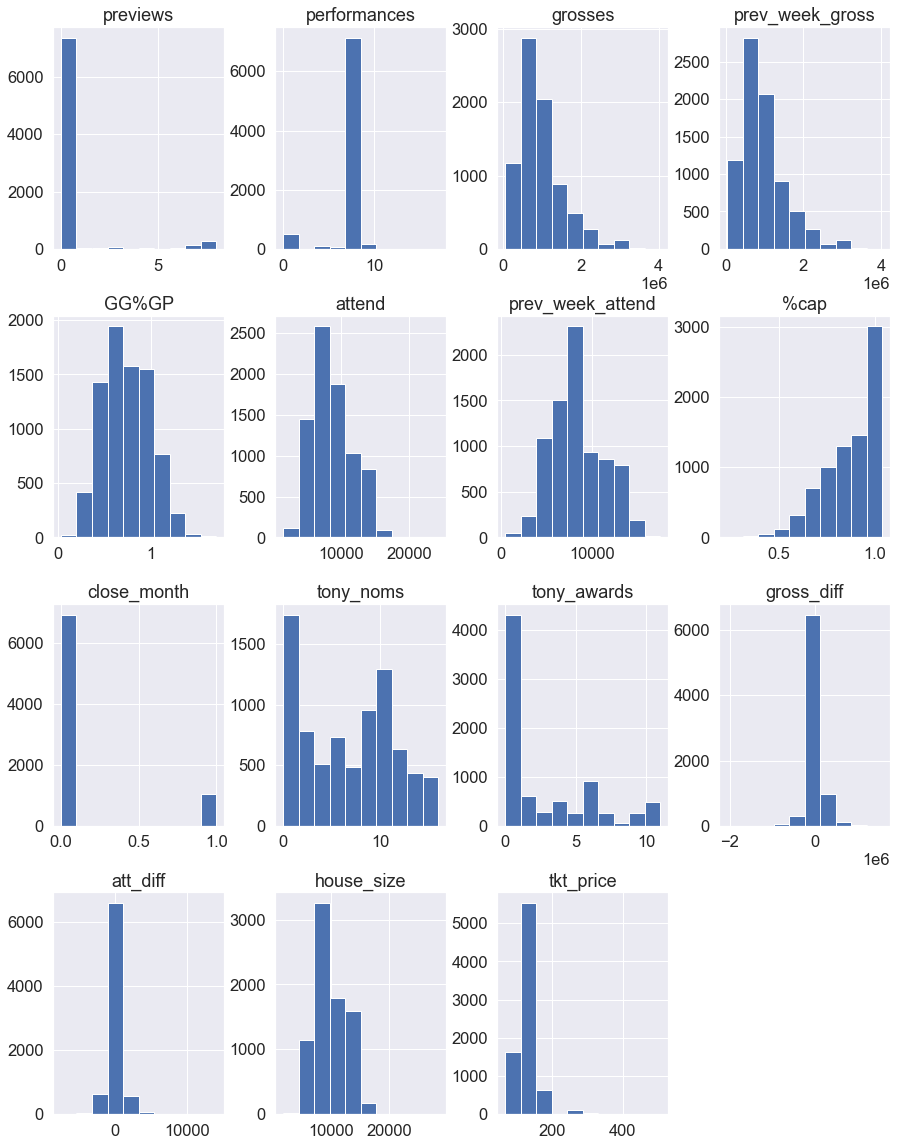

In [24]:
#A histogram of all quantitative features is usually my first step.  
#  Although this is quick and rough it shows us that we have very pretty evenly distributed data
df.hist(figsize=(15,20))
plt.show()

We are going to take a deeper look into 3 specific shows: Hamilton, Anastasia, and Beetlejuice.
Items to note about each show as follows:

**Hamilton**- Definitely what we consider an anomolie.  The success of a show like Hamilton is extremely rare and we see by the visualizations of their data that it has abnormal habits.  Not a great show data wise to reference.

**Anastasia**-  This show is your average broadway show.  It ran for over a year and opened to great numbers that were sometimes over 1 million a week threshold. However we can see its decline very clearly from the graphs.

**Matilda**-  An interesting show to take a look at.  It was considered very successful and ran for a number of years.  However it never achieved quite the success of Hamilton so it could be a little fuzzy on a show like this.s

### Hamilton Data
Used to do EDA of Hamilton specifically.

In [25]:
#creating three data frames each for the respective show.
df_hamilton = df[df.show.str.contains('Hamilton')]

In [26]:
df_hamilton.head()

show     type          theatre  previews  performances  \
date                                                                     
2015-07-26  Hamilton  Musical  Richard Rodgers         7             0   
2015-08-02  Hamilton  Musical  Richard Rodgers         8             0   
2015-08-09  Hamilton  Musical  Richard Rodgers         4             4   
2015-08-16  Hamilton  Musical  Richard Rodgers         0             8   
2015-08-23  Hamilton  Musical  Richard Rodgers         0             8   

            grosses  prev_week_gross  GG%GP  attend  prev_week_attend  %cap  \
date                                                                          
2015-07-26  1302511        1288436.0   1.12    9290            9273.0  1.00   
2015-08-02  1490816        1302511.0   1.12   10619            9290.0  1.00   
2015-08-09  1255163        1490816.0   0.94   10638           10619.0  1.01   
2015-08-16  1459314        1255163.0   1.09   10706           10638.0  1.01   
2015-08-23  1456753        1459314.0   1.09   10708           10706.0  1.01   

            close_month  genre  tony_noms  tony_awards  gross_diff  att_diff  \
date                                                                           
2015-07-26            0  Drama         16           11     14075.0      17.0   
2015-08-02            0  Drama         16           11    188305.0    1329.0   
2015-08-09            0  Drama         16           11   -235653.0      19.0   
2015-08-16            0  Drama         16           11    204151.0      68.0   
2015-08-23            0  Drama         16           11     -2561.0       2.0   

            house_size   tkt_price  
date                                
2015-07-26      9290.0  125.183665  
2015-08-02     10619.0  125.349441  
2015-08-09     10533.0  126.771080  
2015-08-16     10600.0  126.303791  
2015-08-23     10602.0  126.058351

### Matilda Data
Matilda specific EDA.

In [27]:
df_matilda = df[df.show.str.contains('Matilda')]

In [28]:
df_matilda.head()

show     type  theatre  previews  performances  grosses  \
date                                                                     
2015-01-04  Matilda  Musical  Shubert         0             8  1502817   
2015-01-11  Matilda  Musical  Shubert         0             8   879385   
2015-01-18  Matilda  Musical  Shubert         0             8   987374   
2015-01-25  Matilda  Musical  Shubert         0             8   805176   
2015-02-01  Matilda  Musical  Shubert         0             8   682942   

            prev_week_gross  GG%GP  attend  prev_week_attend  %cap  \
date                                                                 
2015-01-04        1637071.0   1.18   11543           11541.0  1.01   
2015-01-11        1502817.0   0.69   10640           11543.0  0.93   
2015-01-18         879385.0   0.77   11041           10640.0  0.96   
2015-01-25         987374.0   0.63   10110           11041.0  0.88   
2015-02-01         805176.0   0.54    9085           10110.0  0.79   

            close_month    genre  tony_noms  tony_awards  gross_diff  \
date                                                                   
2015-01-04            0  Classic         13            5   -134254.0   
2015-01-11            0  Classic         13            5   -623432.0   
2015-01-18            0  Classic         13            5    107989.0   
2015-01-25            0  Classic         13            5   -182198.0   
2015-02-01            0  Classic         13            5   -122234.0   

            att_diff  house_size   tkt_price  
date                                          
2015-01-04       2.0     11429.0  111.433523  
2015-01-11    -903.0     11441.0  111.395072  
2015-01-18     401.0     11501.0  111.494991  
2015-01-25    -931.0     11489.0  111.241809  
2015-02-01   -1025.0     11500.0  109.974557

### Anastasia Data
Anastasia specific EDA.

In [29]:
df_anastasia = df[df.show.str.contains('Anastasia')]

In [30]:
df_anastasia

show     type     theatre  previews  performances  grosses  \
date                                                                          
2017-04-02  Anastasia  Musical  Broadhurst         7             0   971783   
2017-04-09  Anastasia  Musical  Broadhurst         7             0   922021   
2017-04-16  Anastasia  Musical  Broadhurst         8             0  1207938   
2017-04-23  Anastasia  Musical  Broadhurst         8             0   989231   
2017-04-30  Anastasia  Musical  Broadhurst         0             8   882853   
...               ...      ...         ...       ...           ...      ...   
2019-03-03  Anastasia  Musical  Broadhurst         0             8   557480   
2019-03-10  Anastasia  Musical  Broadhurst         0             8   681938   
2019-03-17  Anastasia  Musical  Broadhurst         0             8   837803   
2019-03-24  Anastasia  Musical  Broadhurst         0             8   920068   
2019-03-31  Anastasia  Musical  Broadhurst         0             8  1012316   

            prev_week_gross  GG%GP  attend  prev_week_attend  %cap  \
date                                                                 
2017-04-02         629307.0   0.97    8012            4572.0  1.00   
2017-04-09         971783.0   0.92    7847            8012.0  0.98   
2017-04-16         922021.0   1.05    9196            7847.0  1.01   
2017-04-23        1207938.0   0.86    9061            9196.0  0.99   
2017-04-30         989231.0   0.77    9030            9061.0  0.99   
...                     ...    ...     ...               ...   ...   
2019-03-03         638470.0   0.51    7020            7576.0  0.77   
2019-03-10         557480.0   0.62    7499            7020.0  0.82   
2019-03-17         681938.0   0.77    9055            7499.0  0.99   
2019-03-24         837803.0   0.84    8948            9055.0  0.98   
2019-03-31         920068.0   0.93    8744            8948.0  0.96   

            close_month    genre  tony_noms  tony_awards  gross_diff  \
date                                                                   
2017-04-02            0  Classic          2            0    342476.0   
2017-04-09            0  Classic          2            0    -49762.0   
2017-04-16            0  Classic          2            0    285917.0   
2017-04-23            0  Classic          2            0   -218707.0   
2017-04-30            0  Classic          2            0   -106378.0   
...                 ...      ...        ...          ...         ...   
2019-03-03            1  Classic          2            0    -80990.0   
2019-03-10            1  Classic          2            0    124458.0   
2019-03-17            1  Classic          2            0    155865.0   
2019-03-24            1  Classic          2            0     82265.0   
2019-03-31            0  Classic          2            0     92248.0   

            att_diff  house_size   tkt_price  
date                                          
2017-04-02    3440.0      8012.0  125.042205  
2017-04-09    -165.0      8007.0  125.165073  
2017-04-16    1349.0      9105.0  126.350043  
2017-04-23    -135.0      9153.0  125.671212  
2017-04-30     -31.0      9121.0  125.705771  
...              ...         ...         ...  
2019-03-03    -556.0      9117.0  119.896681  
2019-03-10     479.0      9145.0  120.273373  
2019-03-17    1556.0      9146.0  118.965214  
2019-03-24    -107.0      9131.0  119.956089  
2019-03-31    -204.0      9108.0  119.511619  

[104 rows x 19 columns]

## Time Plots

In [31]:
#importing plotly

import plotly.express as px

### % Capacity Filled

**HAMILTON**

This sort of time plot for a Broadway show is definitely unprecedented.  The graph looks extremely random, but the show is in such high demand that if you look at the %Capacity on the y axis, the capacity only wavers by a 100th of a percent, therefore giving this graph an unusual look.  All capacity is above 100%.

In [32]:
px.line(df_hamilton, x=df_hamilton.index, y='%cap')

**Matilda**

Hard to tell what is going on in this.

In [33]:
px.line(df_matilda, x=df_matilda.index, y='%cap')

**ANASTASIA**

Same idea, although there are major seasonality and marketing spikes, there is a clear negative relationship with the amount of people coming to this show over time.

In [34]:
px.line(df_anastasia, x=df_anastasia.index, y='%cap')

### Weekly Grosses

**HAMILTON**

I have to assume that merchandise is a large part of these large numbers.  Although they are able to sell the tickets at a steep price for this show a 4 million dollar week on Broadway is unheard of.

In [35]:
px.line(df_hamilton, x=df_hamilton.index, y='grosses', title='Hamilton Grosses')

**MATILDA**

Again looking at this, very difficult to tell what a producer should do.

In [36]:
px.line(df_matilda, x=df_matilda.index, y='grosses', title='Matilda Grosses')

**ANASTASIA**

Again a downward trend, negative linear relationship.

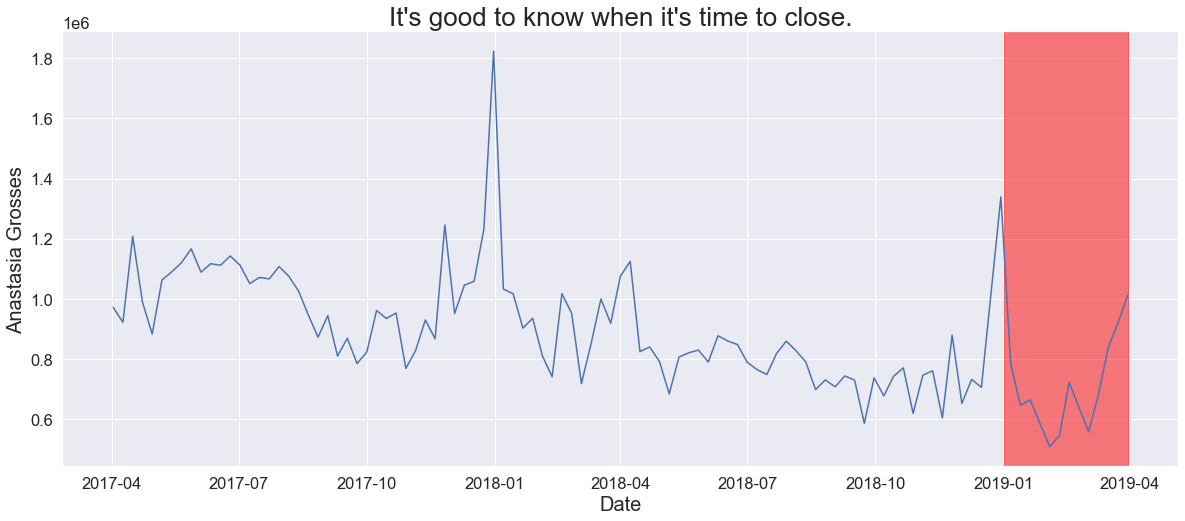

In [37]:
import matplotlib.dates as mdates
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(20,8))

ax = sns.lineplot(data=df_anastasia, x=df_anastasia.index, y='grosses')
ax.axvspan(*mdates.datestr2num(['01/01/2019', '03/31/2019']), color='red', alpha=0.5)

plt.xlabel("Date", fontsize=20)
plt.ylabel("Anastasia Grosses", fontsize=20)
plt.title("It's good to know when it's time to close.", fontsize=26)
plt.tight_layout
plt.show()

The above graph is a crucial visualization of how our 'close_date' feature works.  It marks the last month of performances.  The idea is tha the model will evaluate all of the other features happening during this band of time and begin to form pattern recognition in order to flag it.  

## General EDA

These are the average grossings by type. I believe that the average grossings for Special performances is so high due to the fact that they have predetermined closing dates making them higher in demand.  We are eventually going to drop all special performances for this reason.

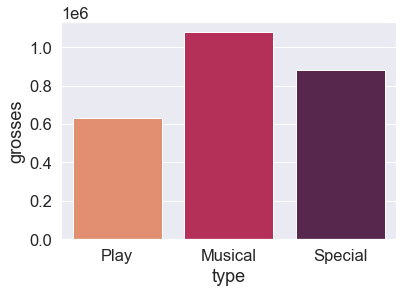

In [38]:
sns.barplot(data=df, x='type', y='grosses', palette = 'rocket_r', ci=None)
plt.show()

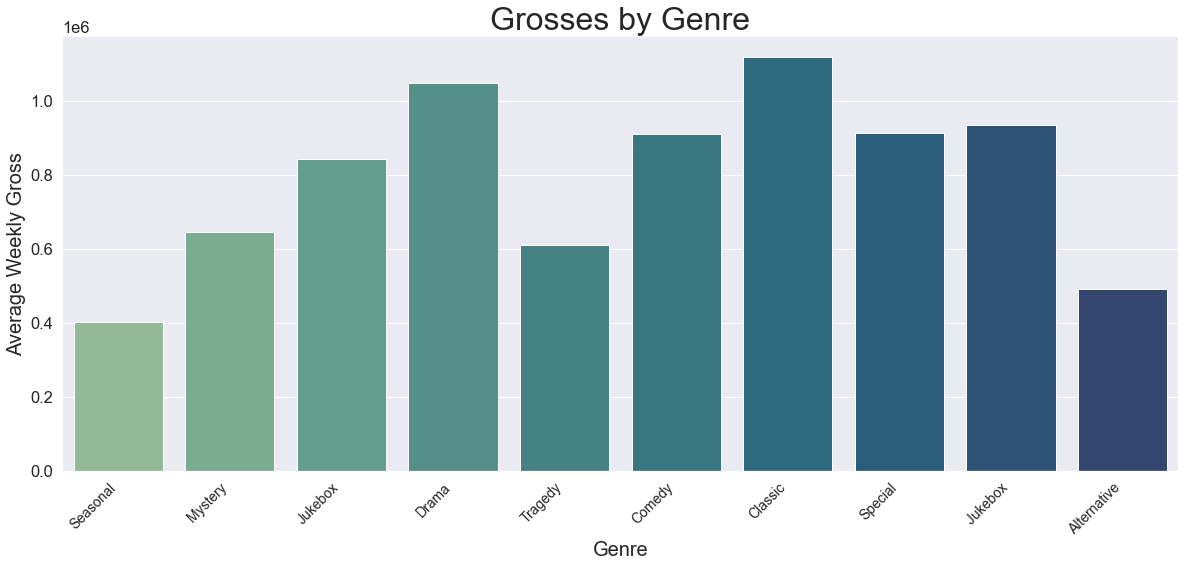

In [39]:
fig, ax = pyplot.subplots(figsize=(20,8))

g = sns.barplot(data=df, x='genre', y='grosses', palette= 'crest', ci=None)
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right', fontsize=14)

plt.xlabel("Genre", fontsize=20)
plt.ylabel("Average Weekly Gross", fontsize=20)
plt.title("Grosses by Genre", fontsize=32)
plt.tight_layout
plt.show()

### Musicals

In [40]:
#creating a data frame from all musicals
df_musical = df[df.type.str.contains('Musical')]

In [41]:
df_musical.head()

show     type   theatre  previews  performances  \
date                                                                     
2019-03-31  Ain't too proud  Musical  Imperial         0             8   
2019-03-10  Ain't too proud  Musical  Imperial         7             0   
2019-03-17  Ain't too proud  Musical  Imperial         7             0   
2019-03-24  Ain't too proud  Musical  Imperial         4             4   
2019-04-07  Ain't too proud  Musical  Imperial         0             8   

            grosses  prev_week_gross  GG%GP  attend  prev_week_attend  %cap  \
date                                                                          
2019-03-31  1330046        1102218.0   0.92   11176           11378.0  0.98   
2019-03-10   872597         472627.0   0.70    9233            4164.0  0.93   
2019-03-17   949781         872597.0   0.76    9810            9233.0  0.98   
2019-03-24  1102218         949781.0   0.76   11378            9810.0  1.00   
2019-04-07  1337083        1330046.0   0.93   10943           11176.0  0.96   

            close_month    genre  tony_noms  tony_awards  gross_diff  \
date                                                                   
2019-03-31            0  Jukebox         12            1    227828.0   
2019-03-10            0  Jukebox         12            1    399970.0   
2019-03-17            0  Jukebox         12            1     77184.0   
2019-03-24            0  Jukebox         12            1    152437.0   
2019-04-07            0  Jukebox         12            1      7037.0   

            att_diff  house_size   tkt_price  
date                                          
2019-03-31    -202.0     11404.0  126.771499  
2019-03-10    5069.0      9928.0  125.560752  
2019-03-17     577.0     10010.0  124.846338  
2019-03-24    1568.0     11378.0  127.464127  
2019-04-07    -233.0     11399.0  126.127174

In [42]:
#The number of musicals in this data set
df_musical.show.nunique()

94

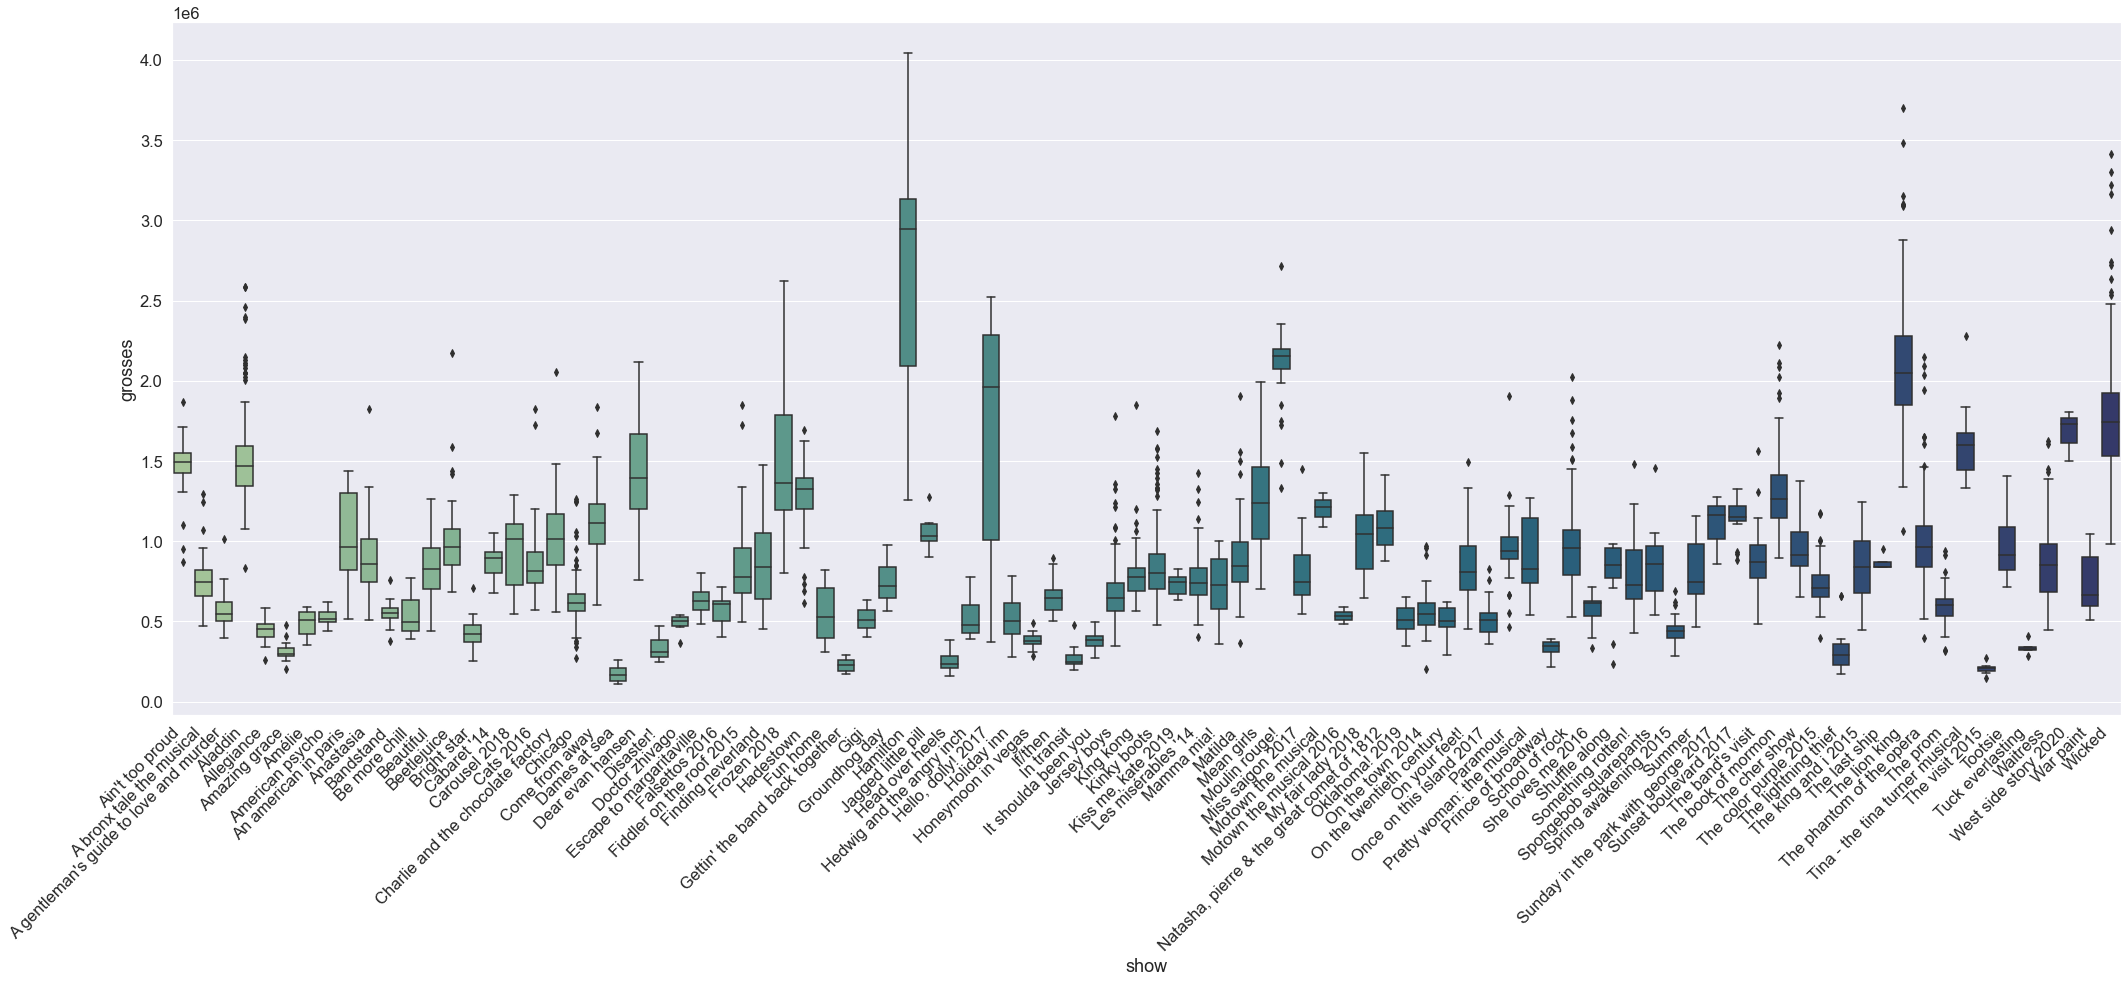

In [43]:
fig, ax = pyplot.subplots(figsize=(30,14))

#set to g and make adjustments.
g = sns.boxplot(data=df_musical, x='show', y='grosses', palette='crest')
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [44]:
df_noms = df_musical[df_musical['tony_noms']>=1]
df_awards = df_musical[df_musical['tony_awards']>=1]

In [45]:
print(df_noms.shape)
print(df_awards.shape)

(5402, 19)
(3948, 19)


In [46]:
df_noms.nunique()

show                  69
type                   1
theatre               37
previews               9
performances           9
grosses             5396
prev_week_gross     5396
GG%GP                135
attend              3666
prev_week_attend    3680
%cap                  65
close_month            2
genre                  7
tony_noms             14
tony_awards           12
gross_diff          5367
att_diff            2435
house_size          2753
tkt_price           5402
dtype: int64

In [47]:
#creating a df for visualization that sorts tony nominations from most to least and filters out no nominations.
df_noms_final = df_noms.sort_values('tony_noms', ascending=False)
df_noms_final.head()

show     type          theatre  previews  performances  \
date                                                                     
2015-12-27  Hamilton  Musical  Richard Rodgers         0             8   
2018-06-24  Hamilton  Musical  Richard Rodgers         0             8   
2019-02-03  Hamilton  Musical  Richard Rodgers         0             8   
2019-02-10  Hamilton  Musical  Richard Rodgers         0             8   
2019-02-17  Hamilton  Musical  Richard Rodgers         0             8   

            grosses  prev_week_gross  GG%GP  attend  prev_week_attend  %cap  \
date                                                                          
2015-12-27  1844837        1658598.0   1.38   10747           10728.0  1.02   
2018-06-24  3132866        3131174.0   1.08   10756           10754.0  1.02   
2019-02-03  3128049        3147991.0   1.03   10754           10753.0  1.02   
2019-02-10  3108317        3128049.0   1.13   10757           10754.0  1.02   
2019-02-17  2947001        3108317.0   1.07   10740           10757.0  1.02   

            close_month  genre  tony_noms  tony_awards  gross_diff  att_diff  \
date                                                                           
2015-12-27            0  Drama         16           11    186239.0      19.0   
2018-06-24            0  Drama         16           11      1692.0       2.0   
2019-02-03            0  Drama         16           11    -19942.0       1.0   
2019-02-10            0  Drama         16           11    -19732.0       3.0   
2019-02-17            0  Drama         16           11   -161316.0     -17.0   

            house_size   tkt_price  
date                                
2015-12-27     10536.0  126.882916  
2018-06-24     10545.0  275.087895  
2019-02-03     10543.0  288.052810  
2019-02-10     10546.0  260.830932  
2019-02-17     10529.0  261.582918

In [48]:
df_awards_final = df_awards.sort_values('tony_awards', ascending=False)
df_awards_final.head()

show     type          theatre  previews  performances  \
date                                                                     
2017-04-16  Hamilton  Musical  Richard Rodgers         0             8   
2017-07-09  Hamilton  Musical  Richard Rodgers         0             8   
2016-12-25  Hamilton  Musical  Richard Rodgers         0             8   
2017-01-01  Hamilton  Musical  Richard Rodgers         0             8   
2017-01-08  Hamilton  Musical  Richard Rodgers         0             8   

            grosses  prev_week_gross  GG%GP  attend  prev_week_attend  %cap  \
date                                                                          
2017-04-16  3117682        2978761.0   1.07   10753           10754.0  1.02   
2017-07-09  3061008        3053850.0   1.16   10755           10753.0  1.02   
2016-12-25  3303538        2240488.0   1.05   10755           10738.0  1.02   
2017-01-01  3335430        3303538.0   1.06   10755           10755.0  1.02   
2017-01-08  2456491        3335430.0   1.03   10754           10755.0  1.02   

            close_month  genre  tony_noms  tony_awards  gross_diff  att_diff  \
date                                                                           
2017-04-16            0  Drama         16           11    138921.0      -1.0   
2017-07-09            0  Drama         16           11      7158.0       2.0   
2016-12-25            0  Drama         16           11   1063050.0      17.0   
2017-01-01            0  Drama         16           11     31892.0       0.0   
2017-01-08            0  Drama         16           11   -878939.0      -1.0   

            house_size   tkt_price  
date                                
2017-04-16     10542.0  276.391718  
2017-07-09     10544.0  250.265554  
2016-12-25     10544.0  298.390238  
2017-01-01     10544.0  298.428687  
2017-01-08     10543.0  226.211014

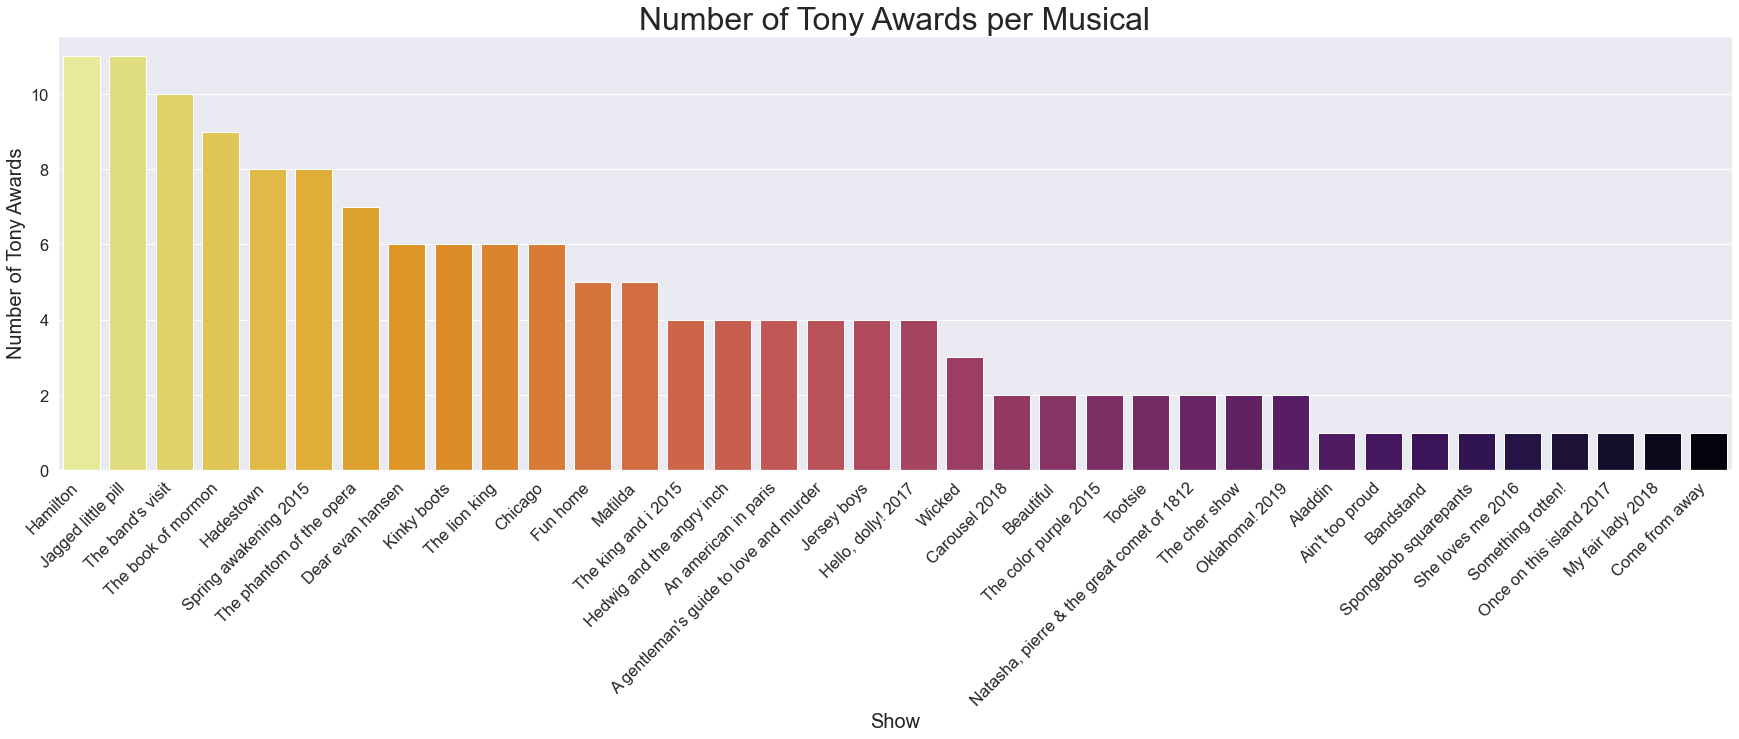

In [49]:
fig, ax = pyplot.subplots(figsize=(30,8))

ax = sns.barplot(data=df_awards_final, x='show', y='tony_awards', palette='inferno_r')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.xlabel("Show", fontsize=20)
plt.ylabel("Number of Tony Awards", fontsize=20)
plt.title("Number of Tony Awards per Musical", fontsize=32)
plt.tight_layout
plt.show()


**People vote with their dollar.**
Important to note what shows won a lot of tony awards versus what stayed open and made money.  Many times what the artistic community finds entrinsically valuable is not the same as what the public places value on.
Shuffle Along earned 10 Tony nominations and closing after a few months at a low house capacity.
Aladdin earned 5 and remains one of the top grossing shows on Broadway.

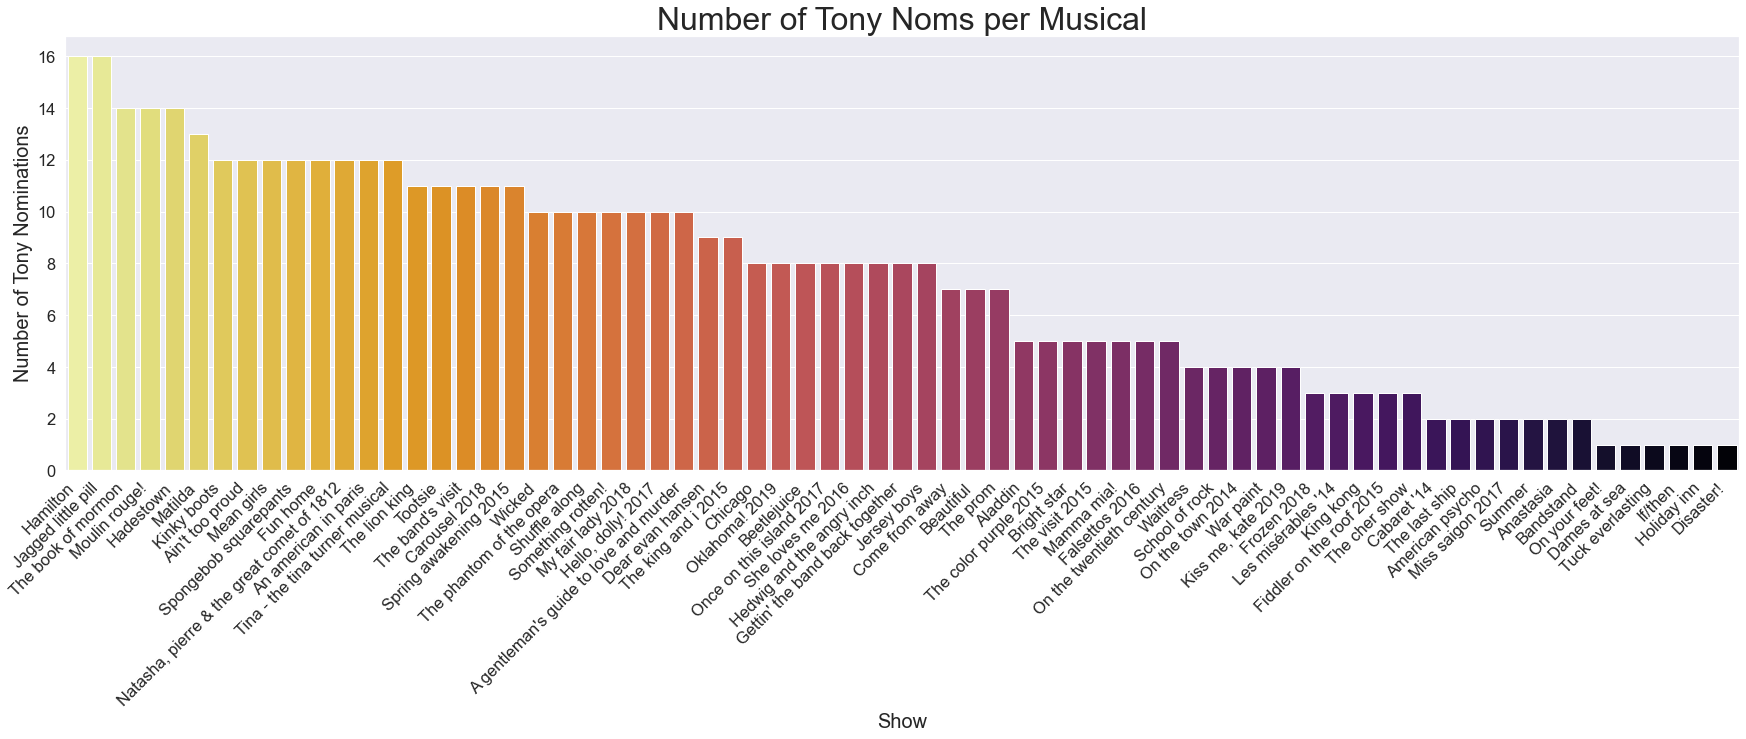

In [50]:
fig, ax = pyplot.subplots(figsize=(30,8))

ax = sns.barplot(data=df_noms_final, x='show', y='tony_noms', palette='inferno_r')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.xlabel("Show", fontsize=20)
plt.ylabel("Number of Tony Nominations", fontsize=20)
plt.title("Number of Tony Noms per Musical", fontsize=32)
plt.tight_layout
plt.show()

### Plays

In [51]:
#creating a data frame for all plays.
df_play = df[df.type.str.contains('Play')]

In [52]:
df_play.head()

show  type theatre  previews  performances  \
date                                                                       
2019-11-17  A christmas carol 2019  Play  Lyceum         8             0   
2019-11-24  A christmas carol 2019  Play  Lyceum         1             7   
2019-12-01  A christmas carol 2019  Play  Lyceum         0             9   
2019-12-08  A christmas carol 2019  Play  Lyceum         0             8   
2019-12-15  A christmas carol 2019  Play  Lyceum         0             8   

            grosses  prev_week_gross  GG%GP  attend  prev_week_attend  %cap  \
date                                                                          
2019-11-17   257525         106450.0   0.30    4194            1651.0  0.62   
2019-11-24   384493         257525.0   0.45    5590            4194.0  0.82   
2019-12-01   734745         384493.0   0.77    5988            5590.0  0.78   
2019-12-08   757702         734745.0   0.90    6164            5988.0  0.91   
2019-12-15   822983         757702.0   0.97    6619            6164.0  0.98   

            close_month     genre  tony_noms  tony_awards  gross_diff  \
date                                                                    
2019-11-17            0  Seasonal          5            3    151075.0   
2019-11-24            0  Seasonal          5            3    126968.0   
2019-12-01            0  Seasonal          5            3    350252.0   
2019-12-08            0  Seasonal          5            3     22957.0   
2019-12-15            0  Seasonal          5            3     65281.0   

            att_diff  house_size   tkt_price  
date                                          
2019-11-17    2543.0      6765.0  126.890860  
2019-11-24    1396.0      6817.0  125.337962  
2019-12-01     398.0      7677.0  124.295205  
2019-12-08     176.0      6774.0  124.282715  
2019-12-15     455.0      6754.0  125.619793

<function matplotlib.pyplot.show(close=None, block=None)>

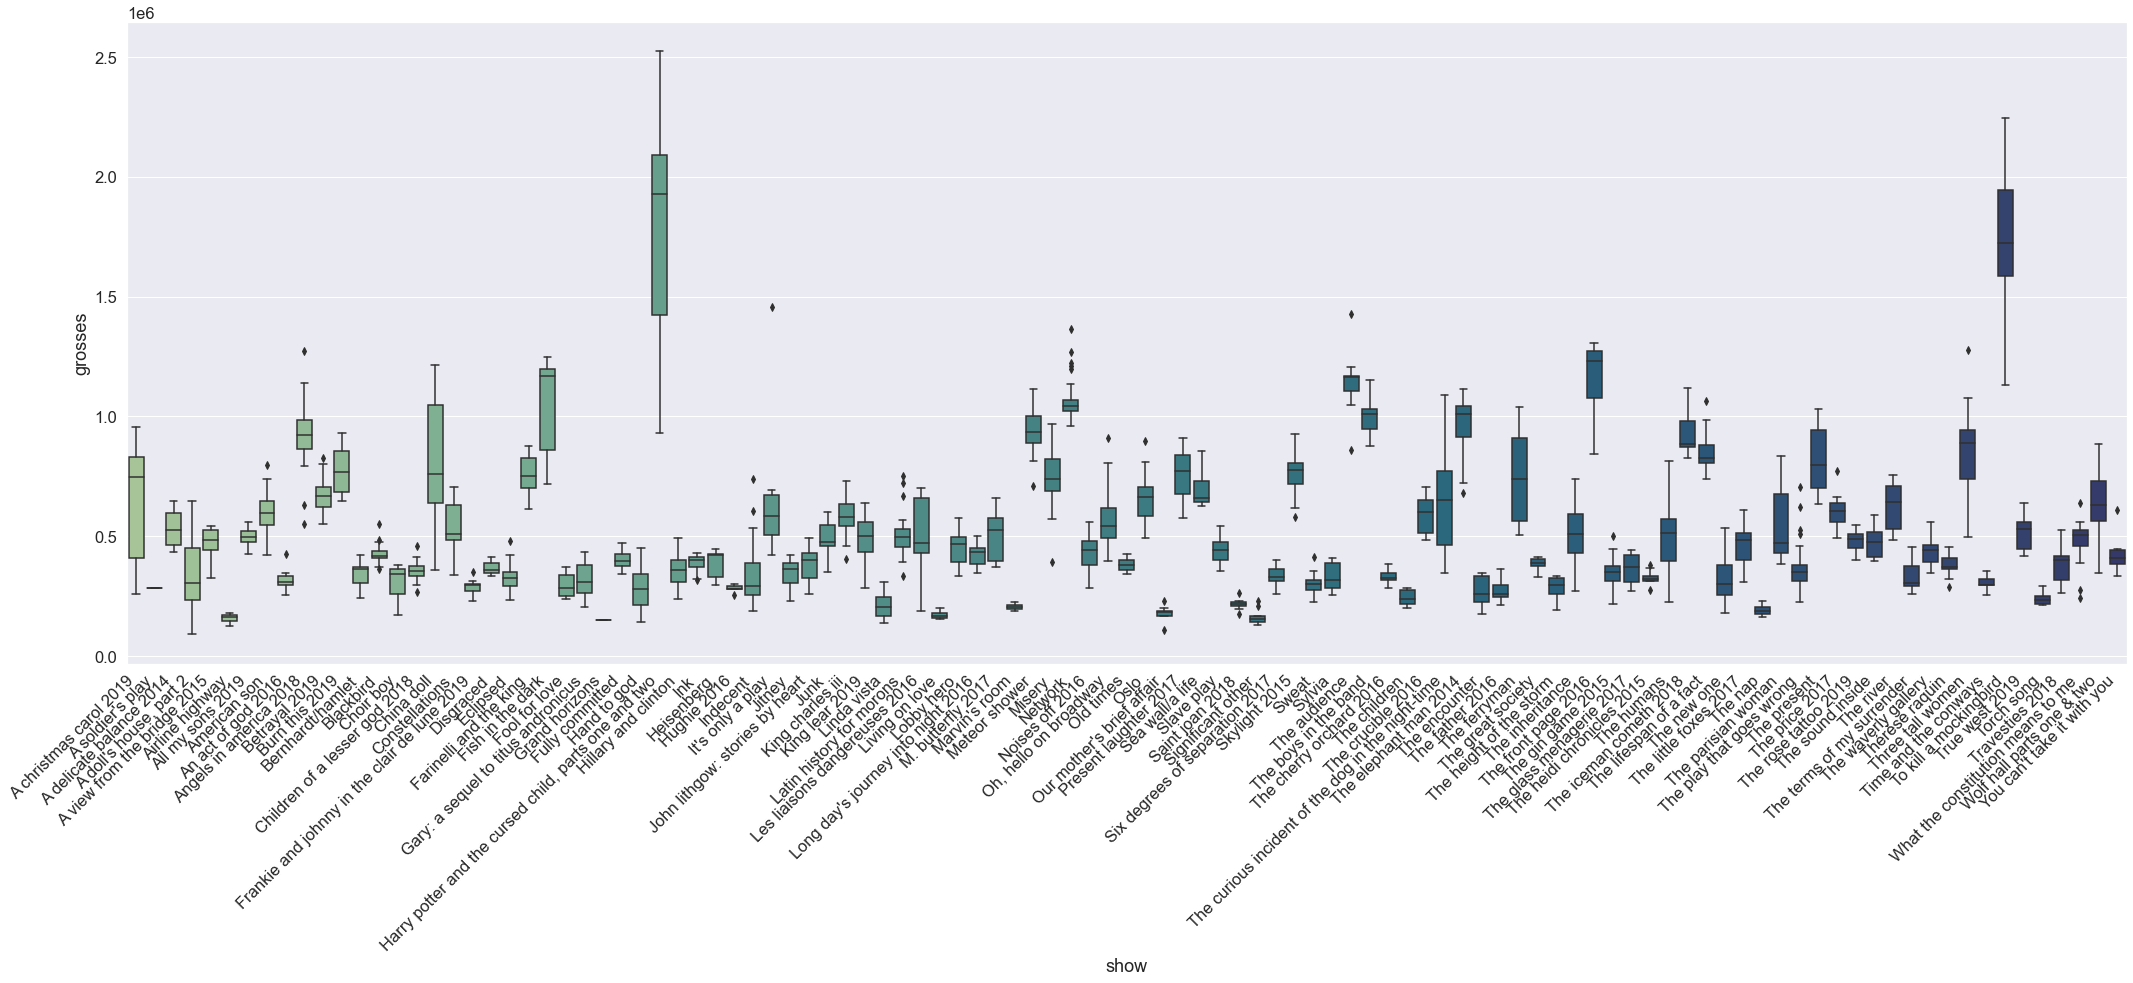

In [53]:
fig, ax = pyplot.subplots(figsize=(30,14))

g = sns.boxplot(data=df_play, x='show', y='grosses', palette='crest')
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show

<AxesSubplot:xlabel='%cap', ylabel='grosses'>

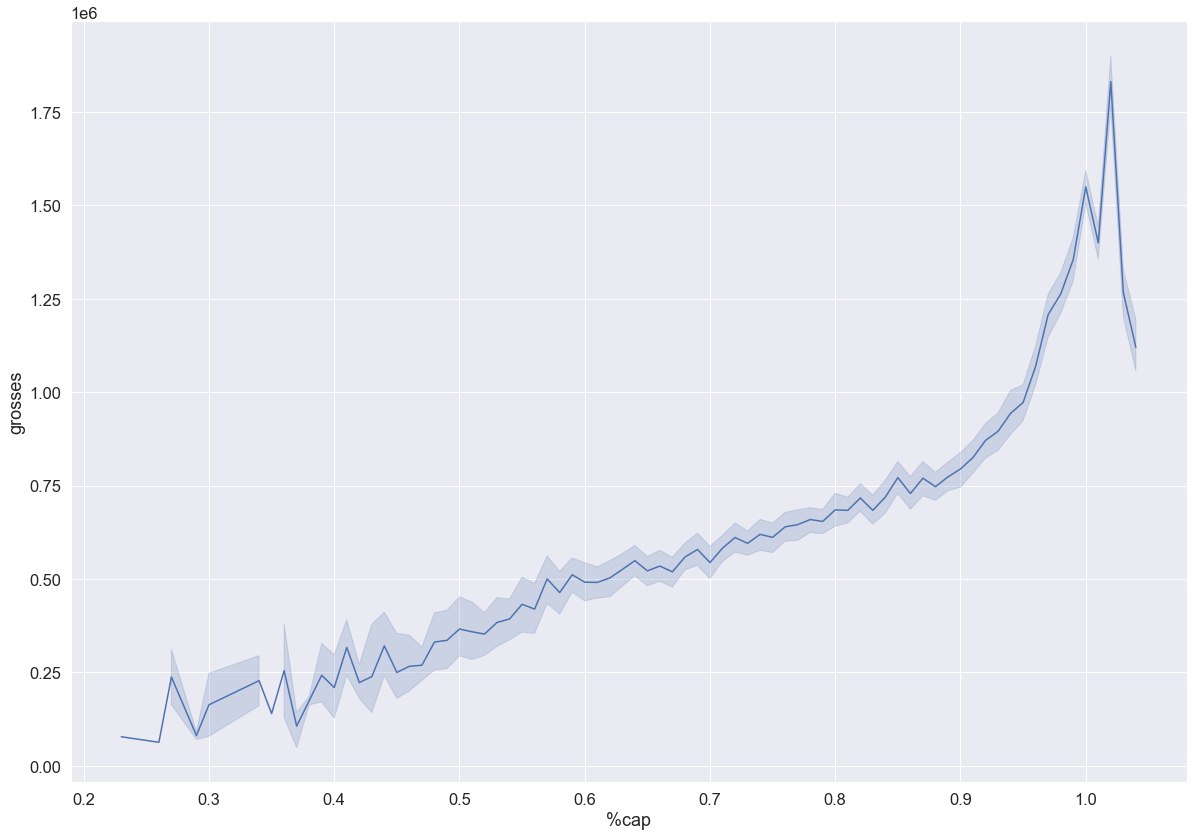

In [54]:
#Looking at the amount the house was filled v how much it made.  
#No surprise strong linear trend.
fig, ax = pyplot.subplots(figsize=(20,14))
sns.lineplot(data=df, x='%cap', y='grosses')

# Baseline Modeling 

In [55]:
#We need to get rid of all special performances as they will influence our data negatively.
df = df[~df.type.str.contains("Special")]

In [56]:
#Checking to make sure that we did not loose too many data points.
df.shape

(7840, 19)

## One Hot Encoding

In [57]:
#get dummies
df = pd.get_dummies(df, columns = ['show', 'type', 'theatre', 'genre'], drop_first = True)

In [58]:
#These numbers will be important later for us to know how many columns that created.
df.shape

(7840, 266)

**CREATE VARIABLES**

In [59]:
#set X equal to our closing data and the rest become features.
X = df.drop('close_month', axis = 1)
y = df['close_month']

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Models

Regression methods were used for this situation.

**SVM**

**Logistic Regression**

**Random Forest**

**XGBoost**




## SVM

Its important to point out at the beginning that the SVM model struggled the most with only predicting one class.  Typically this is contributed to class imbalance which we have in this business problem.  SMOTE did not originally help and so hyper parameters were adjusted in tandem with using SMOTE for best results. 
the original settings I had for hyperparameters were:

**kernel** = 'linear'
**C** = 1
**gamma** = 2**-5

After extensive reading on SVM hyper parameters, the ones below were the final contenders.  For an extensive explanation as to why these settings were chosen please check out my medium.com article [here](https://ozbunae.medium.com/class-imbalance-and-hyperparameters-in-svm-ce8b0f8f9e97).

In [61]:
#import model
from sklearn.svm import SVC
svcls = SVC(kernel='rbf', C=25, gamma = 'scale')
#Kernel is a method of implementing linear classification.
# C is a hypermeter set before training model and used to control error.
# Gamma also a hypermeter which is set before the training model and used to give curvature weight of the decision boundary.
svc = svcls.fit(X_train, y_train)

In [62]:
y_pred_svc = svcls.predict(X_test)

In [63]:
from sklearn.metrics import classification_report

In [64]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93      1691
           1       0.00      0.00      0.00       269

    accuracy                           0.86      1960
   macro avg       0.43      0.50      0.46      1960
weighted avg       0.74      0.86      0.80      1960



C:\Users\ozbun\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\ozbun\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\ozbun\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [65]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred_svc)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[1691    0]
 [ 269    0]]


In [66]:
from sklearn.metrics import plot_confusion_matrix

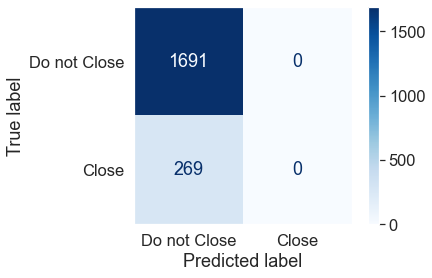

In [67]:
plot_confusion_matrix(svc, X_test, y_test, cmap=plt.cm.Blues, display_labels = ['Do not Close', 'Close'])
plt.grid(False)
plt.show()

So the confusion matrix above is terrible. My original thought was because of the Class Imbalance in the closing month column. SVMs cleverly tend to try and get the highest accuracy possible, which can mean predicting everything as one class for safe measures.
Class imbalance is handled below.

### Class Imbalance

The reason this is such an issue is that many classification learning algorithms have low predictive accuracy for the infrequent class.  Highly plausible cause for above confusion matrix and classification report.

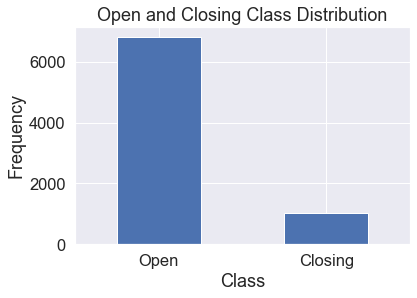

In [68]:
count_classes = pd.value_counts(df['close_month'], sort = True)
count_classes.plot(kind = 'bar', rot=0)

plt.title("Open and Closing Class Distribution")
plt.xticks((0,1), ('Open', 'Closing'))
plt.xlabel("Class")
plt.ylabel("Frequency")

plt.show()

### SMOTE

SMOTE stands for Synthetic Minority Oversampling Technique. This is a statistical technique for increasing the number of cases in your dataset in a balanced way.  SMOTE takes the entire dataset as an input, but it increases the percentage of only the minority cases.  Similar to boostrapping.

In [69]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)


##finding shortcuts for printing clean data results
print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (Percentage):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (7840, 265)
Shape of X after SMOTE: (13622, 265)

Balance of positive and negative classes (Percentage):


1    50.0
0    50.0
Name: close_month, dtype: float64

In [97]:
#Really important cell this is where X and y train/test get reassigned to the SMOTE data.
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(
    X_sm, y_sm, test_size=0.25, random_state=42)


### SVM Rerun

In [98]:
svc = svcls.fit(X_train_sm, y_train_sm)
y_pred_svc = svcls.predict(X_test)

In [99]:
cnf_matrix = confusion_matrix(y_test, y_pred_svc)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[1167  578]
 [ 351 1310]]


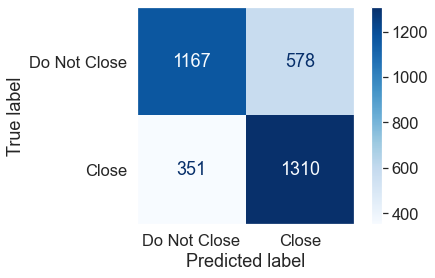

In [100]:
plot_confusion_matrix(svc, X_test, y_test, cmap=plt.cm.Blues, display_labels = ['Do Not Close', 'Close'])
plt.grid(False)
plt.show()

In [74]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.77      0.67      0.72      1745
           1       0.69      0.79      0.74      1661

    accuracy                           0.73      3406
   macro avg       0.73      0.73      0.73      3406
weighted avg       0.73      0.73      0.73      3406



Although this isn't the best confusion matrix ever, it is a more pragmatic approach than our model predicting everything as one class. 

**Please Note** SMOTE alone did not take care of the issue of our model predicting one class.  Originally SMOTE just switched which class the model was predicting.  It was the combination of adjusting hyper parameters and using SMOTE that allowed this model to function properly.

## Logistic Regression

Unlike Linear Regression Logistic Regression accounts for Categorical variables.
Although logistic regression is better than linear regression at dealing with categorical variables, it still is not a great model compared to the other algorithmic models that are in this set of trials. The logistic regression model was discarded early on.

In [101]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
model_log = logreg.fit(X_train_sm, y_train_sm)
model_log

LogisticRegression()

In [102]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train_sm)

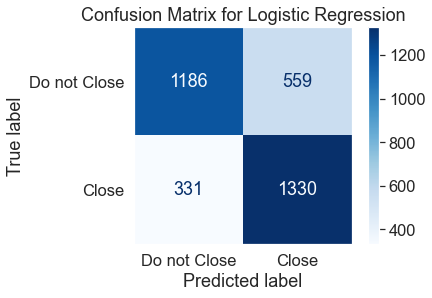

In [103]:
plot_confusion_matrix(model_log, X_test, y_test, cmap=plt.cm.Blues, display_labels = ['Do not Close', 'Close'])
plt.grid(False)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [104]:
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.78      0.68      0.73      1745
           1       0.70      0.80      0.75      1661

    accuracy                           0.74      3406
   macro avg       0.74      0.74      0.74      3406
weighted avg       0.74      0.74      0.74      3406



Not the best accuracy but way better than how the SVM performed.

# Ensemble Methods

Ensemble methods use several base models for one optimal predictive model.[1]

## Random Forest

In [105]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#max depth:
#max leaf nodes:
clf = RandomForestClassifier(n_estimators=100, max_depth=32,  
                             max_leaf_nodes=40)
rf_clf = clf.fit(X_train_sm,y_train_sm)

y_pred_rf = clf.predict(X_test)

In [106]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1745
           1       0.89      0.89      0.89      1661

    accuracy                           0.89      3406
   macro avg       0.89      0.89      0.89      3406
weighted avg       0.89      0.89      0.89      3406



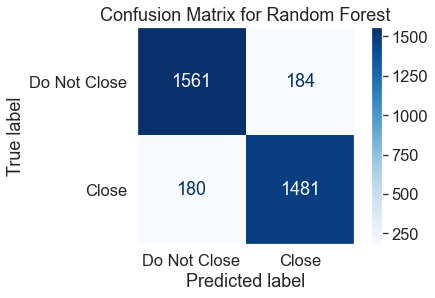

In [107]:
plot_confusion_matrix(rf_clf, X_test, y_test,  cmap=plt.cm.Blues, display_labels = ['Do Not Close', 'Close'] )
plt.title('Confusion Matrix for Random Forest')
plt.grid(False)
plt.show()

The above classification report and confusion matrix are actually very nice looking. After adjusting the hyperparameters a few times I finally settled on what I have now which gave me an accuracy of 90% without being too overfit.   

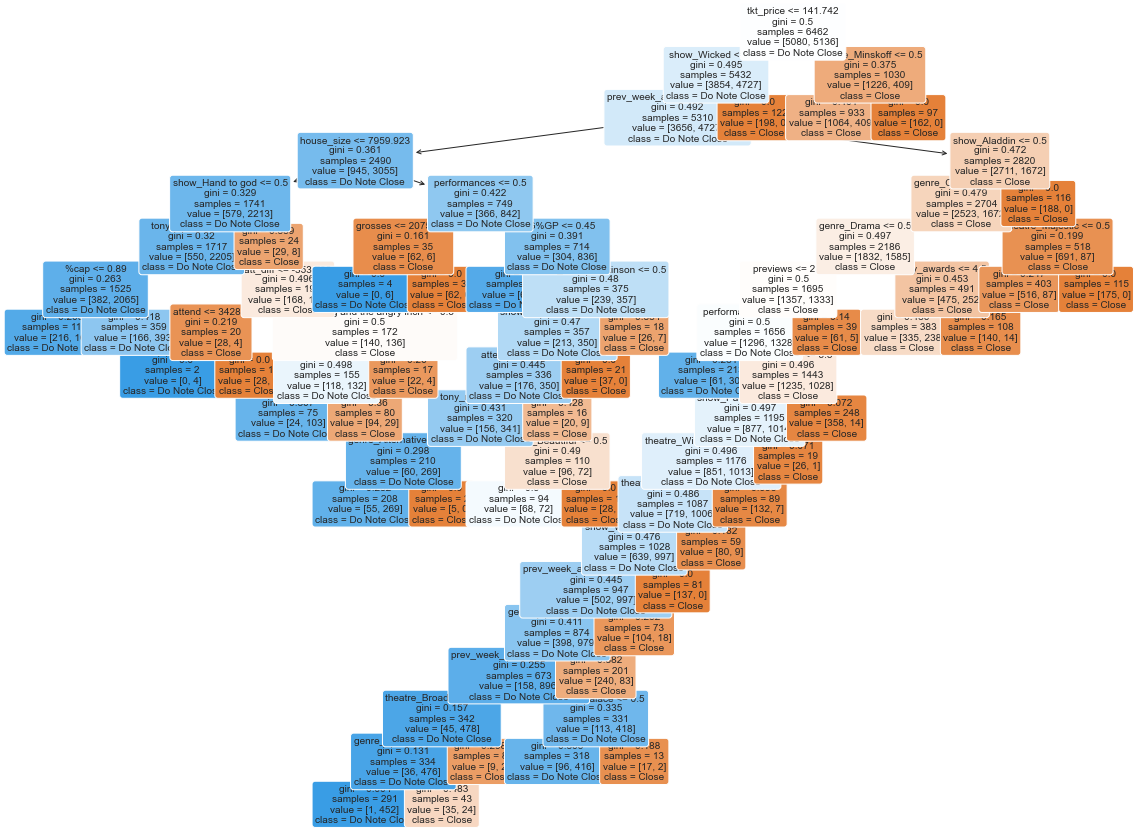

In [114]:
## Initial overfitting in this plot
from sklearn import tree
plt.figure(figsize = (20,15))
tree.plot_tree(rf_clf.estimators_[2], rounded = True, 
               filled = True, 
               class_names = ['Close', 'Do Note Close'], 
               feature_names = X.columns, fontsize = 10)
plt.show()

### Overfitting

**A note on the overfitting**
Finding the balance on over and underfitting on this model was extremely difficult.  There are still sometimes where the above chart looks very overfit.  
My guess for all of the overfitting is that because long running shows keep aquiring new data without closing.  I am sure this is confusing to the model, still working on how to solve this.

## XG Boost 

XGBoost is a popular and efficient open-source implementation of the gradient boosted trees algorithm. When using gradient boosting for regression, the weak learners are regression trees, and each regression tree maps an input data point to one of its leaves that contains a continuous score.

In [83]:
import xgboost as xgb
from xgboost import XGBClassifier

In [109]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
xgb_df = clf_xgb.fit(X_train_sm, y_train_sm, verbose = True)

C:\Users\ozbun\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[08:46:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [110]:
y_pred_xgb = clf_xgb.predict(X_test)

C:\Users\ozbun\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [111]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1745
           1       0.95      0.94      0.95      1661

    accuracy                           0.95      3406
   macro avg       0.95      0.95      0.95      3406
weighted avg       0.95      0.95      0.95      3406



C:\Users\ozbun\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



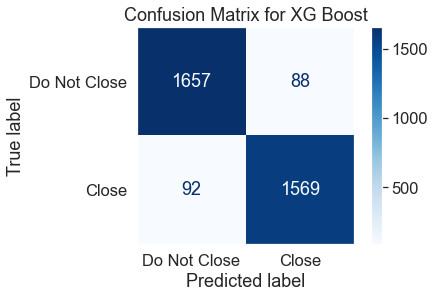

In [112]:
plot_confusion_matrix(clf_xgb, X_test, y_test, cmap=plt.cm.Blues, display_labels = ['Do Not Close', 'Close']) 
plt.title('Confusion Matrix for XG Boost')
plt.grid(False)
plt.show()

# Feature Importance

While it is great that we can predict when a broadway show is going to close with such high accuracy, we also have to wonder what the main things were that influenced the computers decision.

In [88]:
important_features_dict = {}
for idx, val in enumerate(clf.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print('9 most important features:', important_features_list[:9])

9 most important features: [3, 8, 6, 12, 9, 5, 2, 258, 4]


In [89]:
data = important_features_dict
col = X.columns.tolist()

df_fi = pd.DataFrame.from_dict(data, orient='index',
                               columns=['feat_im'])
df_fi['feature'] = col

df_fi.head()

feat_im          feature
0  0.031782         previews
1  0.031869     performances
2  0.055833          grosses
3  0.080049  prev_week_gross
4  0.043883            GG%GP

In [90]:
df_sorted = df_fi.sort_values('feat_im', ascending=False)
df_final = df_sorted.iloc[:9]

In [91]:
df_final.head(9)

feat_im           feature
3    0.080049   prev_week_gross
8    0.078692         tony_noms
6    0.069613  prev_week_attend
12   0.063239        house_size
9    0.062808       tony_awards
5    0.059200            attend
2    0.055833           grosses
258  0.044372      genre_Comedy
4    0.043883             GG%GP

 🛎 **IMPORTANT** 
Please note that that these labels must be changed according to what the result of the previous cell states.  Features are subject to change.

In [92]:
# These are the original labels in order from the first time I ran this feature importance function.
# This object created below can be used to make the labels on the x axis cleaner and tigher.
# After running this multiple times, although the features shift around slightly this is a pretty good summation of the results.
labels = ['Previous Weeks Attendance', '# Tony Nominations', 'Previous Weeks Gross', 'Current Gross', 'GG%GP',
          '# Tony Awards', 'Jukebox Musical Genre', 'Current Attendance', 'Comedy Genre']

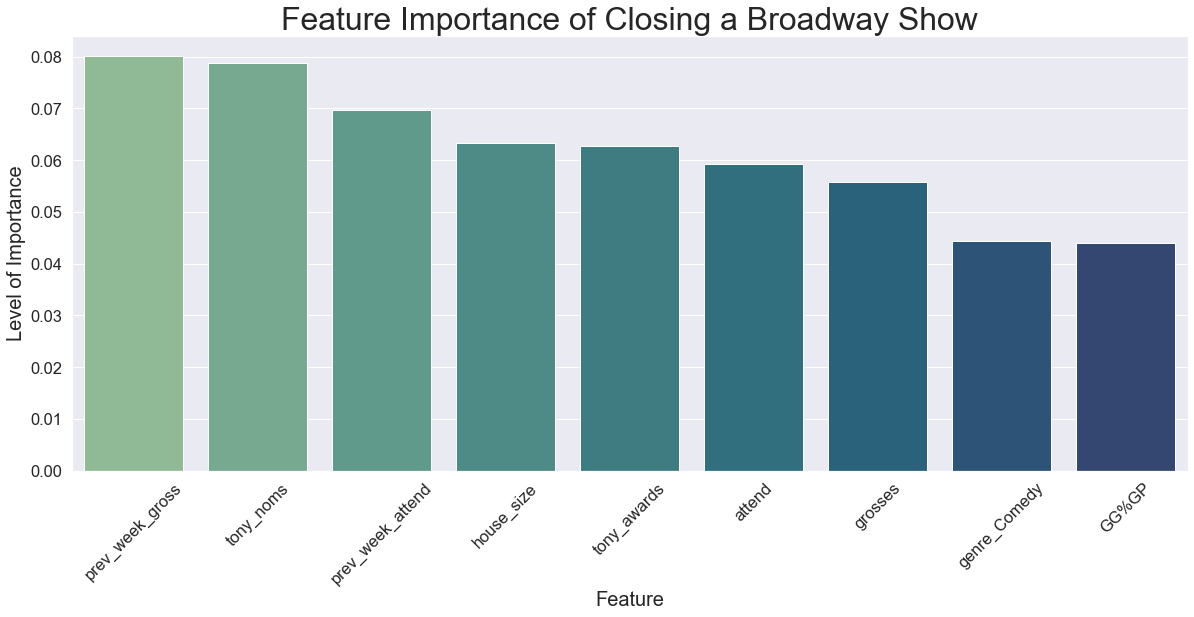

In [93]:
fig, ax = pyplot.subplots(figsize=(20,8))

g = sns.barplot(data=df_final, x='feature', y='feat_im', palette= 'crest')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.xlabel("Feature", fontsize=20)
plt.ylabel("Level of Importance", fontsize=20)
plt.title("Feature Importance of Closing a Broadway Show", fontsize=32)
plt.tight_layout
plt.show()

Looking at the original graph above, it makes sense.  Its actually ideal that the data from the previous week is two of the first three most important features.  This means that the computer picked up on the fact that numbers were declining to a certain level and so it should classify it as time to close.

# Conclusion

## SVM and Neural Networks

Both an SVM and Neural Networks were attempted to do these predictions.  Both methods behaved similarly.  When running the data through the crude primary versions of these, I kept running into the issue of only predicting one class.  It became the bane of this project.

Subsequently, I found this interesting:

"Both Support Vector Machines (SVMs) and Artificial Neural Networks (ANNs) are supervised machine learning classifiers. An ANN is a parametric classifier that uses hyper-parameters tuning during the training phase. An SVM is a non-parametric classifier that finds a linear vector (if a linear kernel is used) to separate classes. Actually, in terms of the model performance, **SVMs are sometimes equivalent to a shallow neural network architecture.** Generally, an ANN will outperform an SVM when there is a large number of training instances, however, neither outperforms the other over the full range of problems."[2]

This happened for this data. The SVM and the neural network behaved similarly in how they were trying to classify the outcome. My gut instinct was class imbalance.  However it is important to remember that when class imbalance was adjusted with SMOTE it just flip flopped sides. Once the hyperparameters were tuned we had a highly functional model.  

I cannot say that the ANN had the same success.
Methods implemented for ANN include:
- Adjusting the learning rate.
- Reducing the amount of nodes in a layer.
- Applying SMOTE.
- Dropout Layers.
- Adjusting weights.
- Using stochastic gradient descent. 

Ultimately my thought are that a neural network is too complex of a machine learning model for a binary classification problem with integers (as opposed to large matricies) as data points.  

In [94]:
data = [['SVM',.76, .67, .71], ['Log. Regression',.65, .65, .65], ['XGB',.95,.95,.95], ['Random Forrest',.90,.90,.90]]

df_results = pd.DataFrame(data, columns = ['Model', 'Precision', 'Recall', 'F1'])



In [95]:
df_results

Model  Precision  Recall    F1
0              SVM       0.76    0.67  0.71
1  Log. Regression       0.65    0.65  0.65
2              XGB       0.95    0.95  0.95
3   Random Forrest       0.90    0.90  0.90

In [96]:
px.bar(df_results, x = 'Model', y='Precision')

1. We can accurately predict when a show is in the 'red zone'. However, we do need to spend more time augmenting the data and acquiring more features.

2. Random Forrest Model and XGBoost proved to be the most effective model.

3. When looking at what features a Producer should have their eye on, we can conclude that they should be concerned with the over all decline of the shows numbers, i.e. always comparing the numbers from last week to the current week. Choosing a Jukebox musical or Comedy will have a large influence on how a show will do.  This makes sense when we look at the original EDA.

# Moving Forward

1. Continue to address class imbalance and overfitting. We need to augment the data and number of features heavily.

2. Look into neural networks as another possibility for training and testing data.

3. Create user interface so that a Producer can interact with this.

# References

[1]https://towardsdatascience.com/ensemble-methods-in-machine-learning-what-are-they-and-why-use-them-68ec3f9fef5f

[2]https://www.pico.net/kb/advantages-of-artificial-neural-networks-over-support-vector-machines#:~:text=Both%20Support%20Vector%20Machines%20